In [1]:
import zipfile

#Inclusão da sequência de dados lidas pelo sensor
with zipfile.ZipFile("KITTI-Sequence.zip", "r") as archive:
    archive.extractall("data/")

Scan 0
Scan 1
Scan 2
Scan 3
Scan 4
Scan 5
Scan 6
Scan 7
Scan 8
Scan 9
Scan 10
Scan 11
Scan 12
Scan 13
Scan 14
Scan 15
Scan 16
Scan 17
Scan 18
Scan 19
Scan 20
Scan 21
Scan 22
Scan 23
Scan 24
Scan 25
Scan 26
Scan 27
Scan 28
Scan 29


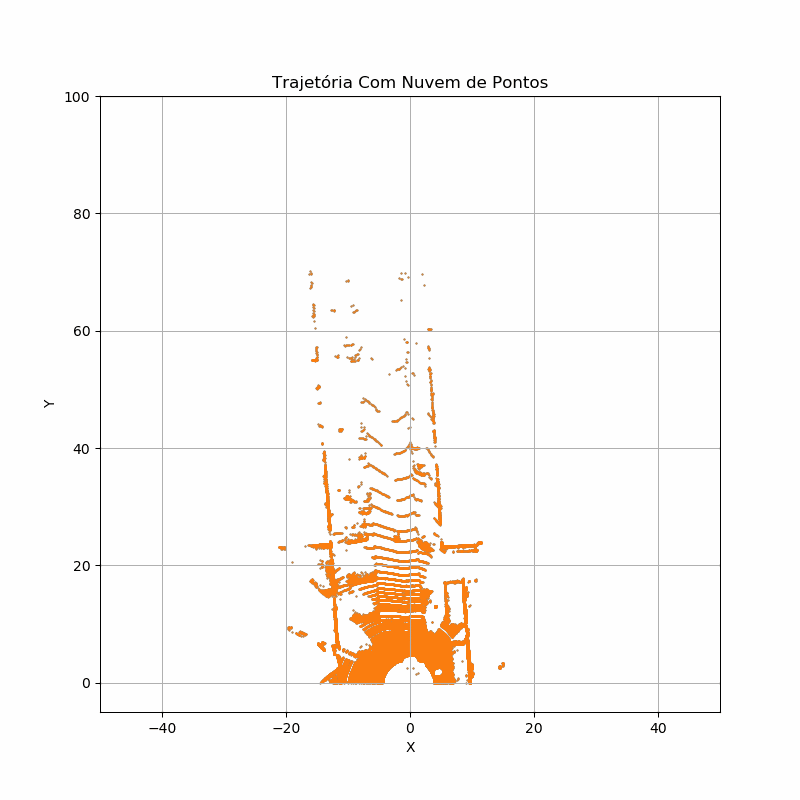

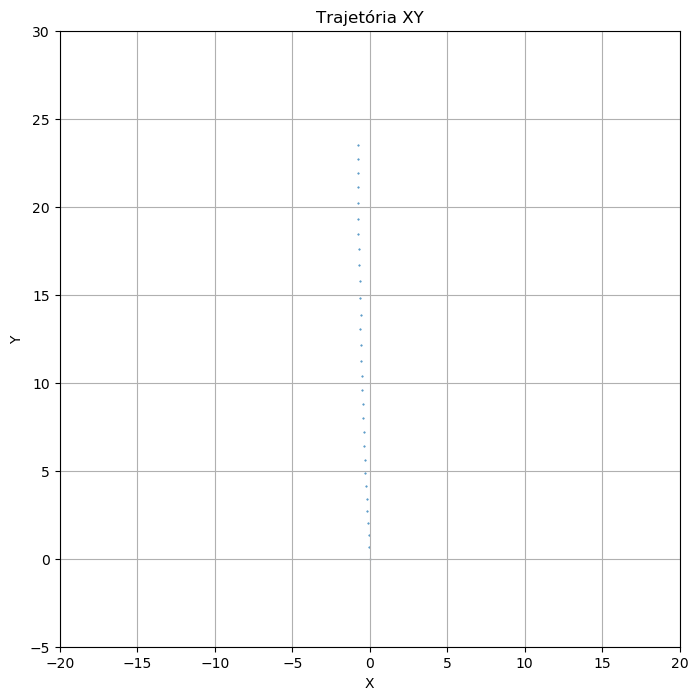

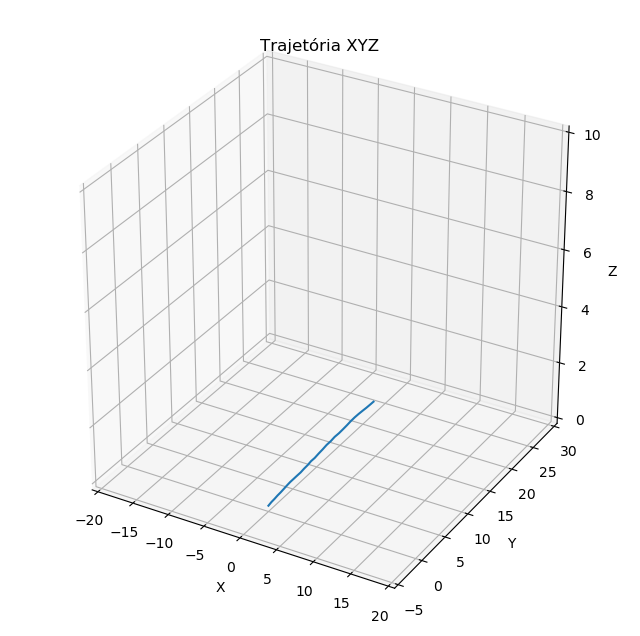

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from IPython.core.display import Image
from IPython.display import Image as DisplayImage
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KDTree

#Leitura dos dados lidos pelo sensor, a partir de suas coordenadas
def load_data(data_path):
    """
    Carrega os dados dos scans LiDAR em formato .obj
    
    Args:
    data_path: O caminho para a pasta que contém os arquivos .obj
    
    Returns:
    Uma lista de matrizes contendo os pontos (x, y, z) de cada scan
    """
    scans = []
    for i in range(30):
        filename = os.path.join(data_path, f"{i:06d}"+"/"+f"{i:06d}_points.obj")
        with open(filename, "r") as f:
            lines = f.readlines()
            points = []
            for line in lines:
                if line.startswith("v "):
                    parts = line.split()
                    x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                    points.append([x, y, z])
            scans.append(np.array(points))
    return scans

# Função para calcular a matriz de transformação entre dois conjuntos de pontos usando o algoritmo ICP
def icp(scan, reference_scan, max_iterations=50, tolerance=1e-6):
    moved_scan = scan.copy()
    for i in range(max_iterations):
        # Seleciona os pontos correspondentes
        reference_scan_matched = find_reference_scan_matched(moved_scan, reference_scan)
        # Verifica se existe pontos correspondentes
        if len(reference_scan_matched) == 0:
            break
        # Estima a transformação que melhor alinha os pontos correspondentes
        R, t, transformation = calculate_transformation(scan, reference_scan_matched)
        # Aplica a transformação a nuvem de pontos
        moved_scan = np.dot(R, scan) + t
        #Erro médio quadrático
        if np.sum(np.sqrt(np.sum((np.dot(R, scan) + t - reference_scan_matched)**2, axis=0)))  < tolerance:
            break
    return R, t, transformation

# Função para encontrar os pares correspondentes entre dois conjuntos de pontos usando o algoritmo KDTree
def find_reference_scan_matched(scan, reference_scan):
    tree = KDTree(reference_scan.T, metric='euclidean')
    indices = tree.query(scan.T, k=1, return_distance=False).reshape(scan.shape[1])
    reference_scan_matched = reference_scan[:, indices]
    return reference_scan_matched

def calculate_centroid(points):
    return np.mean(points, axis=1).reshape((3, 1))

def calculate_transformation(scan, reference_scan_matched):
    # Calculando o centro de massa
    scan_centroid = calculate_centroid(scan)
    reference_scan_matched_centroid = calculate_centroid(reference_scan_matched)
    # Matriz de covariância cruzada
    H = np.dot(scan - scan_centroid, (reference_scan_matched - reference_scan_matched_centroid).T)
    # Decomposição da matriz H em três matrizes
    U, _, V = np.linalg.svd(H)
    #Matriz de rotaçao ideal
    R = np.dot(U, V)
    if np.linalg.det(R) < 0:
        V[2, :] *= -1
        R = np.dot(V.T, U.T)
    #Tranlação
    t = reference_scan_matched_centroid - np.dot(R, scan_centroid)
    #Matriz de transformação, caso fosse necessário
    transformation = np.identity(4)
    transformation[:3, :3] = R
    transformation[:3, 3] = t.T
    return R, t, transformation

def main():
    all_scans = load_data('data')
    R_list = []
    t_list = []
    for i in range(30):
      print("Scan " + str(i))

      R, t, transformation = icp(all_scans[i].T, all_scans[max(i-1, 0)].T, max_iterations=50, tolerance=1e-6)

      # Aplicar a matriz de transformação na nuvem de pontos
      all_scans[i] = (np.dot(R, all_scans[i].T)+t).T

      # Armazenar a matriz de transformação para o plot da trajetória
      R_list.append(R)
      t_list.append(t)

      # Plotar a trajetória da nuvem de pontos
      fig = plt.figure(figsize=(8, 8))
      ax = fig.subplots()
      ax.set_title('Trajetória Com Nuvem de Pontos')
      ax.scatter(all_scans[i][:, 0], all_scans[i][:, 1], s=0.2, label='Scan')
      ax.scatter(all_scans[max(i-1, 0)][:, 0], all_scans[max(i-1, 0)][:, 1], s=0.2, label='Reference Scan')
      ax.set_xlim([-50, 50])
      ax.set_ylim([-5, 100])
      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.grid()
      ax.get_figure().savefig('figures/fig'+str(i)+'.png')
      plt.close()

    # Rotina de geração do .gif
    imgs = (Image.open(f) for f in sorted(glob.glob("figures/fig*.png")))
    img = next(imgs)
    img.save("figures/traj.gif", format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)
    display_gif = DisplayImage(filename="figures/traj.gif")
    display(display_gif)
    
    # Calcular a trajetória percorrida
    trajectory = np.zeros((len(t_list), 3))
    for i in range(len(t_list)):
      # Aplica a transformação na trajetória
      trajectory[i] = R_list[i].dot(trajectory[i]) + t_list[i].T

    # Plotar a trajetória em XY
    fig = plt.figure(figsize=(8, 8))
    ax = fig.subplots()
    ax.set_title('Trajetória XY')
    ax.scatter(trajectory[:, 0], trajectory[:, 1], s=0.2)
    ax.set_xlim([-20, 20])
    ax.set_ylim([-5, 30])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    plt.show()

    # Plotar a trajetória em XYZ
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Trajetória XYZ')
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])
    ax.set_xlim([-20, 20])
    ax.set_ylim([-5, 30])
    ax.set_zlim([0, 10])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid()
    plt.show()

if __name__ == '__main__':
    main()
